<a href="https://colab.research.google.com/github/LLF00/datascience1/blob/main/Assignment3_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os
from datetime import datetime
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

C:\Users\lifen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = "trained_model"
checkpoint_path = "checkpoints/" + timestamp + "/model.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
log_dir = "logs/fit/" + timestamp

In [3]:
'''
After check the image dimension distribution, we need to resize and normalize the image for trianing purpose.
Theare are many ways to resize the image, I did some research on some releated research papers.
Reference paper:
MobileNetV2:Inverted Residuals and Linear Bottlenecks
Following the paper suggestion, I will resize the impage as the paper did, which is 224 x 224
'''
INPUT_SHAPE = (224, 224, 3)

# Information from the dataset description
NUM_BREEDS = 120


In [4]:
def load_dataset():
    '''
    Tensorfolw standfor_dogs dataset info:
    - Link: https://www.tensorflow.org/datasets/catalog/stanford_dogs
    - The dataset contains images of 120 breeds of dogs from around the world.
    - Total images in this dataset: 20,580
      - Train: 12,000
      - Test: 8580
    - Class labels and bounding box annotations ae provided fo r all 12,000 (train data) images

    Feature structure info for tfds:
        FeaturesDict({
            'image': Image(shape=(None, None, 3), dtype=uint8),
            'image/filename': Text(shape=(), dtype=string),
            'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
            'objects': Sequence({
                'bbox': BBoxFeature(shape=(4,), dtype=float32),
            }),
        })
    '''
    # (train, test), data_info = tfds.load('stanford_dogs', split=['train', 'test'], shuffle_files=True, with_info=True, data_dir='./tfds_dogs_dataset')
    (train, test), data_info = tfds.load('stanford_dogs', split=['train', 'test'], shuffle_files=True, with_info=True)

    return train, test, data_info

In [5]:
def get_image_data_info(dataset, dataset_flag):
    image_width, image_height = [], []
    for data in dataset:
        width = data['image'].shape[0]
        height = data['image'].shape[1]
        image_width.append(width)
        image_height.append(height)

    # visualize the image dimension distribution
    plt.subplot(211)
    plt.hist(x=image_width, bins=20, alpha=0.7, density=True)
    # plt.axvline(max(set(img_width), key=img_width.count), color='r')
    plt.ylabel('Pixels')
    plt.ylabel('Frequency')
    plt.title('Image width distribution')
    plt.grid(axis='y', alpha=0.75)

    plt.subplot(212)
    plt.hist(x=image_height, bins=20, alpha=0.7)
    # plt.axvline(max(set(img_height), key=img_height.count), color='r')
    plt.xlabel('Pixels')
    plt.ylabel('Frequency')
    plt.title('Image height distribution')
    plt.grid(axis='y', alpha=0.75)

    plt.subplots_adjust(hspace=0.5)
    # plt.savefig('{}_data_width_height_distribution.png'.format(dataset_flag))
    plt.show()


In [6]:
def image_preprocess(image_data, image_size, num_labels):
    '''
    After check the image dimension distribution, we need to resize and normalize the image for trianing purpose.
    Theare are many ways to resize the image, I did some research on some releated research papers.
    Reference paper:
    MobileNetV2:Inverted Residuals and Linear Bottlenecks
    Following the paper suggestion, I will resize the impage as the paper did, which is 224 x 224
    '''
    image = image_data['image']
    label = image_data['label']
    # casting image to float32
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, image_size, method='nearest')
    image = image / 255.
    label = tf.one_hot(label, num_labels)

    return image, label

In [7]:
def data_pipeline(dataset, image_shape, num_classes, batch_size=None):
    dataset = dataset.map(lambda x: image_preprocess(x, image_shape[0:-1], num_classes),
                          num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    if batch_size:
        dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [8]:
def cnn_model(image_shape, num_classes, lr=0.001):
    model = Sequential([
        Conv2D(16, 3, activation='relu', use_bias=False, padding='same', input_shape=image_shape),
        MaxPool2D(pool_size=(4, 4), strides=(4, 4), padding='same'),
        # Dropout(rate=0.2),
        Conv2D(32, 3, activation='relu', use_bias=False, padding='same'),
        MaxPool2D(pool_size=(4, 4), strides=(4, 4), padding='same'),
        Dropout(rate=0.2),
        Conv2D(64, 3, activation='relu', use_bias=False, padding='same'),
        Conv2D(64, 3, activation='relu', use_bias=False, padding='same'),
        MaxPool2D(pool_size=(3, 3), strides=2),
        # Dropout(rate=0.2),
        Flatten(),
        Dense(128, activation='relu'),
        # Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'top_k_categorical_accuracy']
    )

    return model


In [9]:
def cnn_model2(image_shape, num_classes, lr=0.001):
    '''
    NOTE: this model using MobileNetV2 model from tentorflow. This model has better perforamance with shorter training
    time, but make sure this is valid implementation in your project.
    '''
    base_model = tf.keras.applications.MobileNetV2(input_shape=image_shape,
                                                   include_top=False,
                                                   weights='imagenet')
    base_model.trainable = False
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'top_k_categorical_accuracy']
    )
    return model


In [10]:
def model_train(model, train_batches, test_batches, epochs):
    print("Training model ...")
    print(model.summary())


    # Create a callback for visualization in TensorBoard
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                          histogram_freq=1,
                                                          profile_batch=0)
    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)
    # Train
    model.fit(
        train_batches,
        epochs=epochs,
        validation_data=test_batches,
        callbacks=[tensorboard_callback, cp_callback]
    )

    # save the model weights
    model.save(save_path + "/stanford_dog_cnn")

In [11]:
def model_evaluate(model, test_batches):
    print("Evaluating trained model...")
    metrics = model.evaluate(test_batches, return_dict=True, verbose=1)
    for key, val in metrics.items():
        print(key + ": {:.2f}".format(val))

Loading data

In [12]:
train_data, test_data, data_info = load_dataset()

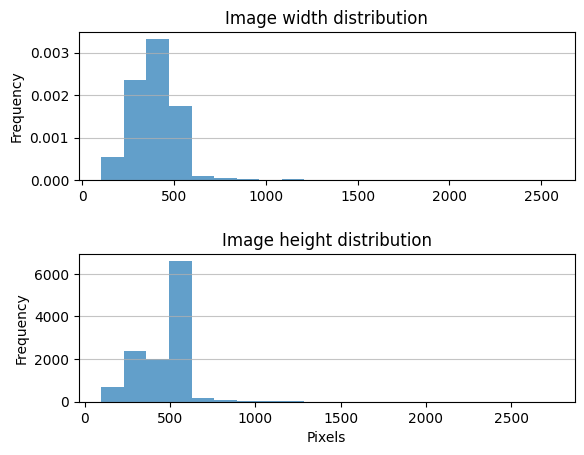

In [13]:
get_image_data_info(train_data, 'train')

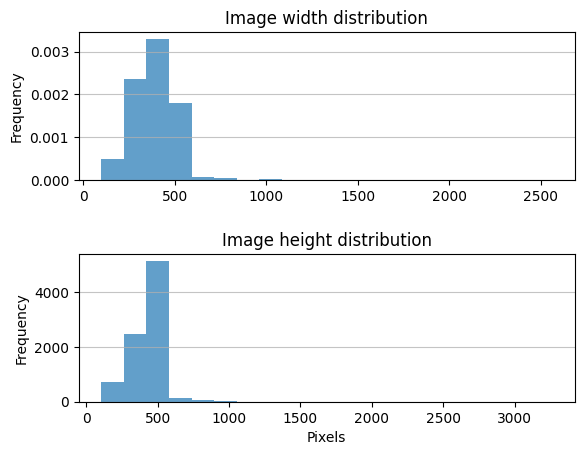

In [14]:
get_image_data_info(test_data, 'test')

In [15]:
train_batches = data_pipeline(train_data, INPUT_SHAPE, NUM_BREEDS, batch_size=16)
test_batches = data_pipeline(test_data, INPUT_SHAPE, NUM_BREEDS,  batch_size=16)

In [16]:
EPOCHS = 100

# Frist CNN model

In [17]:
tf.random.set_seed(123)
model = cnn_model(INPUT_SHAPE, NUM_BREEDS, lr=0.001)
model_train(model, train_batches, test_batches, epochs=EPOCHS)

Training model ...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      432       
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 32)        4608      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 1

INFO:tensorflow:Assets written to: trained_model/stanford_dog_cnn\assets


## Model Evaluation

In [18]:
model_evaluate(model, test_batches)

Evaluating trained model...
537/537 [==============================] - 18s 34ms/step - loss: 16.4453 - accuracy: 0.0580 - top_k_categorical_accuracy: 0.1811
loss: 16.45
accuracy: 0.06
top_k_categorical_accuracy: 0.18


# Second model

In [19]:
EPOCHS2 = 20

In [20]:
tf.random.set_seed(123)
model2 = cnn_model2(INPUT_SHAPE, NUM_BREEDS, lr=0.0001)
model_train(model2, train_batches, test_batches, epochs=EPOCHS2)

Training model ...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 120)               153720    
                                                                 
Total params: 2411704 (9.20 MB)
Trainable params: 153720 (600.47 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
None
Epoch 1/20
750/750 [==============================] - ETA: 0s - loss: 3.3106 - accuracy: 0.2980 - top_k_categorical_acc

INFO:tensorflow:Assets written to: trained_model/stanford_dog_cnn\assets


INFO:tensorflow:Assets written to: trained_model/stanford_dog_cnn\assets


# model Evaluation

In [21]:
model_evaluate(model2, test_batches)

Evaluating trained model...
537/537 [==============================] - 112s 209ms/step - loss: 0.7688 - accuracy: 0.7695 - top_k_categorical_accuracy: 0.9605
loss: 0.77
accuracy: 0.77
top_k_categorical_accuracy: 0.96
